In [1]:
import pykat
import numpy as np

import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
import matplotlib.pyplot as plt

import scipy
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

pykat.init_pykat_plotting(fmts=['svg'])

                                              ..-
    PyKat 1.1.244         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [37]:
%run LHO.py

base = make_LHO()
base.verbose = False
base.dumpify()

# We take a pickoff of the OMC refl and measure the beamscan along there
base.parse("s sOMC_REFL 2 nOMC_ICb nOMC_REFL")

# Data taken for matching the OPO beam to the OMC
# Furthest, Middle, and Closest refer to the second adjustable
# lens position after the OPO. Close means closest to the OPO
Furthest = np.array([[-0.2635,-0.2285,-0.2005,-0.1555,-0.1135],
                     [0.000621,0.000647,0.0006675,0.000714,0.000757],
                     [0.0004515,0.00046,0.000475,0.00049,0.00052]])

Closest  = np.array([[-0.2635,-0.2379,-0.1935,-0.1585,-0.1175],
                     [0.000334,0.000326,0.0003175,0.0003355,0.0003745],
                     [0.000358,0.000344,0.000327,0.000332,0.000354   ]])

Middle   = np.array([[-0.2635,-0.2379,-0.1935,-0.1615,-0.1205         ,1.2255,1.2255,1.2972,1.2972,1.3588,1.3588,1.419,1.419,1.474,1.474  ],
                     [0.000395,0.0003825,0.0004105,0.00043,0.0004585  ,0.001835,0.00182,0.00185,0.001885,0.001935,0.001825,0.002,0.002,0.00185,0.00205   ],
                     [0.000374,0.000373,0.0003735,0.0003885,0.0004055 ,0.001315,0.0013,0.00128,0.00136,0.00136,0.00139,0.001415,0.001345,0.00131,0.001365 ]])

OPO      = np.array([[2.5*25.4e-3, 28.5*25.4e-3, 39.75*25.4e-3, (16.5-2.125)*25.4e-3],
                     [2320e-6, 1830e-6, 1680e-6, 2030e-6],
                     [2301e-6, 1730e-6, 1590e-6, 2000e-6]])


OPO_wo_lens2 = np.array([[2.25*25.4e-3, 4.5*25.4e-3],
                         [4454e-6     , 4918e-6    ],
                         [4530e-6     , 4816e-6    ]])

Middle_SRM_refl_HAM6 = np.array([[1.36, 1.33, 1.3081, 0.4826, 0.433, 0.381 ],
                                 [1786e-6, 1787e-6, 1782e-6, 1768e-6, 1776e-6, 1784e-6],
                                 [2332e-6, 2216e-6, 2209e-6, 2017e-6, 2022e-6, 2043e-6]])


def cav2node(cav_name, node, verbose =True, base=base):
    """
    This method traces a cavity's eigen mode to a
    given node in the model. 
    
    cav_name: cavity name
    node: node to trace beam to
    verbose: More or less info
    base: The kat object to do the tracing with
    """
    kat = base.deepcopy()

    for cav in kat.getAll(pykat.commands.cavity):
        if cav_name not in cav.name:
            cav.remove()

    kat.noxaxis = True
    kat.parse("pd p nAS")

    _, T = kat.run(getTraceData=True)
    qx, qy, _ = T[0][node]
    
    if verbose: print("%s -> %s" % (cav_name, node), qx.q, qy.q)
    return qx, qy


def single_bounce_SQZ(base, direction = 'x', verbose=True, to_node='nAS'):
    """
    This does a single bounce trace off of SRM HR surface from the OPO beam.
    This happens in two parts. Once trace from the OPO to the SRM HR
    a refl off of SRM HR, and then a trace from this reflected beam to
    the requested node.
    
    Returns the final q value going in to the OMC
    """
    SQZqx = base.sqz.nSQZ.qx 
    SQZqy = base.sqz.nSQZ.qy
    
    if direction == 'y':
        qin = SQZqy
    else:
        qin = SQZqx

    SQZ2SRM = base.beamTrace(qin, "nSQZ", "nSRMs1", direction=direction)
    
    #ITMX substrate
    n = base.SRMsub.n.value

    # Manually calculate the reflection off of SRM HR inside substrate
    q2 = pykat.optics.ABCD.apply(base.SRM.ABCD("nSRMs1", "nSRMs1", direction=direction),
                                 SQZ2SRM.q_out,
                                 n, n)

    if to_node != "nSRMs1":
        SRM2OMC = base.beamTrace(q2, "nSRMs1", to_node, direction=direction)

        if verbose:
            SQZ2SRM.print()
            SRM2OMC.print()

        return pykat.BeamParam(q=SRM2OMC.q_out)
    else:
        if verbose:
            SQZ2SRM.print()
        
        return pykat.BeamParam(q=SQZ2SRM.q_out)


Pykat parsing does not preserve inline comments. Moving inline
comments before command



<Figure size 600x370.8 with 0 Axes>

In [38]:
def func_lens2_fit(x, dz1, dz2, direction, base):
    kat = base.deepcopy()

    lens2_actuator_pos = 0.5
    
    if direction == 'x':
        qin = kat.sqz.nSQZ.qx
    else:
        qin = kat.sqz.nSQZ.qy
    
    kat.data['fn_OPO_shift_lenses'](kat, dz1, lens2_actuator_pos, dz2)
    
    trace_SQZ_SRM = kat.beamTrace(qin, 'nSQZ', "nSRMs1", direction=direction)

    return trace_SQZ_SRM.beamsize(x)/1e-3

def func_lens1_fit(x, dz1, direction, base):
    kat = base.deepcopy()

    lens2_actuator_pos = 0.5
    
    if direction == 'x':
        qin = kat.sqz.nSQZ.qx
    else:
        qin = kat.sqz.nSQZ.qy
    
    kat.sqz_lens2.f = np.inf
    
    kat.data['fn_OPO_shift_lenses'](kat, dz1, lens2_actuator_pos, 0)
    
    trace_SQZ_SRM = kat.beamTrace(qin, 'nSQZ', "nSRMs1", direction=direction)
    
    return trace_SQZ_SRM.beamsize(x)/1e-3

# Fit to ZM1 beamscan

We took a beam scan after ZM1 with lens2 in the middle position. Here we fit this beam shape by varying the q value used at the squeezer component. This is then the beam shape that is propagating towards the SRM. Assuming the lengths and lenses before lens2 are good, we can vary the lens2 position and predict the beam at the OMC later.

In [39]:
dz1 = 0
dz2 = 0

kat = base.deepcopy()

def func_lens1_fitx(x, dz1):
    return func_lens1_fit(x, dz1, 'x', kat)

def func_lens1_fity(x, dz1):
    return func_lens1_fit(x, dz1, 'y', kat)

def func_lens2_fitx(x, dz2):
    return func_lens2_fit(x, dz1, dz2, 'x', kat)

def func_lens2_fity(x, dz2):
    return func_lens2_fit(x, dz1, dz2, 'y', kat)


trace_SQZ_SRM_HR = kat.beamTrace(base.sqz.nSQZ.qx, 'nSQZ', "nSRMs1", direction='x')
ZM1_pos          = trace_SQZ_SRM_HR.data['ZM1']['z']

xdata = ZM1_pos + OPO_wo_lens2[0,:]
ydata = OPO_wo_lens2[1,:]/2e-3
p0x = (0)
popt_lens1x, covx = curve_fit(func_lens1_fitx, xdata, ydata, p0=p0x)

xdata = ZM1_pos + OPO_wo_lens2[0,:]
ydata = OPO_wo_lens2[2,:]/2e-3
p0y = (0)
popt_lens1y, covy = curve_fit(func_lens1_fity, xdata, ydata, p0=p0y)

dz1 = (popt_lens1x + popt_lens1y)/2



kat = base.deepcopy()
trace_SQZ_SRM_HR = kat.beamTrace(base.sqz.nSQZ.qx, 'nSQZ', "nSRMs1", direction='x')
ZM1_pos          = trace_SQZ_SRM_HR.data['ZM1']['z']

xdata = ZM1_pos + OPO[0,:]
ydata = OPO[1,:]/2e-3
p0x = (0)
popt_lens1x, covx = curve_fit(func_lens2_fitx, xdata, ydata, p0=p0x)

xdata = ZM1_pos + OPO[0,:]
ydata = OPO[2,:]/2e-3
p0y = (0)
popt_lens1y, covy = curve_fit(func_lens2_fity, xdata, ydata, p0=p0y)


dz2 = (popt_lens1x + popt_lens1y)/2


display("x fit [dz1]", dz1)
display("y fit [dz1]", dz2)

'x fit [dz1]'

array([-0.00601394])

'y fit [dz1]'

array([ 0.00736888])

[-0.00601394] [ 0.00736888]


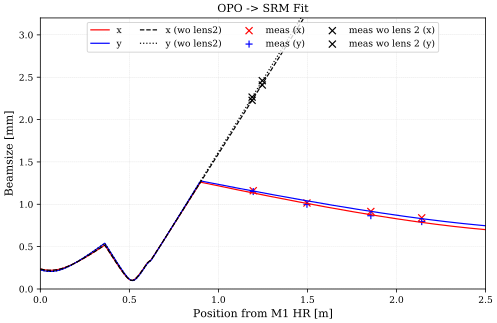

In [40]:
z = np.linspace(0, trace_SQZ_SRM_HR.data['nSRMs1']['z']-0.01, 1000)

plt.figure(figsize=(5*1.6, 5))

plt.plot(z, func_lens2_fitx(z, dz2), 'r', label='x')
plt.plot(z, func_lens2_fity(z, dz2),  'b', label='y')

fval = base.sqz_lens2.f.value
kat.sqz_lens2.f = np.inf

plt.plot(z, func_lens1_fitx(z, dz1), 'k--', label='x (wo lens2)')
plt.plot(z, func_lens1_fity(z, dz1), 'k:',label='y (wo lens2)')

kat.sqz_lens2.f = fval

plt.scatter(ZM1_pos + OPO[0,:], OPO[1,:]/2e-3, 50, color='r', marker='x', label='meas (x)')
plt.scatter(ZM1_pos + OPO[0,:], OPO[2,:]/2e-3, 50, color='b', marker='+', label='meas (y)')

plt.scatter(ZM1_pos + OPO_wo_lens2[0,:], OPO_wo_lens2[1,:]/2e-3, 50, color='k', marker='x', label='meas wo lens 2 (x)')
plt.scatter(ZM1_pos + OPO_wo_lens2[0,:], OPO_wo_lens2[2,:]/2e-3, 50, color='k', marker='x', label='meas wo lens 2 (y)')

plt.xlabel("Position from M1 HR [m]")
plt.ylabel("Beamsize [mm]")
plt.legend(ncol=4, loc="upper center")
plt.title("OPO -> SRM Fit")
plt.xlim(0, 2.5)
plt.ylim(0, 3.2)

# apply positions to base model
base.data['fn_OPO_shift_lenses'](base, dz1, 0.5, dz2)
print(dz1, dz2)

# Project beams to OMC

In [47]:
def SRM_HR_substrate_refl(qix, qiy):
    qx = pykat.optics.ABCD.apply(base.SRM.ABCD("nSRMs1", "nSRMs1", direction='x'),
                                     qix, kat.SRMsub.n.value, kat.SRMsub.n.value)
    qy = pykat.optics.ABCD.apply(base.SRM.ABCD("nSRMs1", "nSRMs1", direction='y'),
                                     qiy, kat.SRMsub.n.value, kat.SRMsub.n.value)
    
    return qx, qy

def run(kat, dz1=dz1, dz2=dz2):
    """
    This function runs the provided kat object to trace the beam form the
    OPO to the OMC. It plots the data taken against the model generated.
    The parameters of the model can be changed by changing the input kat.
    The popt x/y are the optimised qx and qy from the fitting before of the
    beam coming out of the OPO after ZM1.
    """
    fig = plt.figure(figsize=(4*2, 4))
    ax = plt.subplot(111)

    fig2 = plt.figure(figsize=(4*2, 4))
    ax2 = plt.subplot(111)

    # Get cavity OMC q at SRM...
    OMCqx, OMCqy = cav2node('OMC', 'nSRMs1', kat)
    OMCqx.reverse()
    OMCqy.reverse()
    
    # Then trace it back to get the beam shape
    trace_OMCx = kat.beamTrace(OMCqx, 'nSRMs1', "nOMC_REFL",direction='x')
    trace_OMCx.plot_beamsize(ax=ax2, color='k', ls='--', label="OMC")
    trace_OMCy = kat.beamTrace(OMCqy, 'nSRMs1', "nOMC_REFL",direction='y')
    trace_OMCy.plot_beamsize(ax=ax2, color='k', ls=':', label="OMC")
    
    # Loop over the three lens2 options and do the tracing
    #for lens2_pos,c,pos in zip([0.05, 0.5, 0.95], ['r','g','b'], ['Far', 'Middle', 'Close']):
    for lens2_pos,c,pos in zip([0.5], ['g'], ['Middle']):
        #shift_lenses(kat, 0, lens2_pos)
        kat.data['fn_OPO_shift_lenses'](kat, dz1, lens2_pos, dz2)
        
        trace_SQZ_SRMx = kat.beamTrace(kat.sqz.nSQZ.qx, 'nSQZ', "nSRMs1",direction='x')
        trace_SQZ_SRMx.plot_beamsize(ax=ax, color=c, label=pos + '(x)')
        trace_SQZ_SRMy = kat.beamTrace(kat.sqz.nSQZ.qy, 'nSQZ', "nSRMs1",direction='y')
        trace_SQZ_SRMy.plot_beamsize(ax=ax, color=c, label=pos + '(y)', ls='--')
        
        qx, qy = SRM_HR_substrate_refl(trace_SQZ_SRMx.q_out, trace_SQZ_SRMy.q_out)
        
        trace_SRM_OMCx = kat.beamTrace(qx, 'nSRMs1', "nOMC_REFL",direction='x')
        trace_SRM_OMCx.plot_beamsize(ax=ax2, color=c, label=pos + '(x)')
        trace_SRM_OMCy = kat.beamTrace(qy, 'nSRMs1', "nOMC_REFL",direction='y')
        trace_SRM_OMCy.plot_beamsize(ax=ax2, color=c, label=pos + '(y)', ls='--')

        print(pos, "x", pykat.BeamParam.overlap(trace_SRM_OMCx.q_out, trace_OMCx.q_out))
        print(pos, "y", pykat.BeamParam.overlap(trace_SRM_OMCy.q_out, trace_OMCy.q_out))

    OMC_waist_pos = trace_OMCx.data['OM3']['z'] + 0.117 + 0.2 + 0.141
    ZM1_pos = trace_SQZ_SRM_HR.data['ZM1']['z']


    # Factor of two because measurement in diameter
    ax.scatter(ZM1_pos + OPO[0,:], OPO[1,:]/2e-3, color='k', marker='x')
    ax.scatter(ZM1_pos + OPO[0,:], OPO[2,:]/2e-3, color='k', marker='+')

    ax2.scatter(OMC_waist_pos + Furthest[0,:], Furthest[1,:]/1e-3, color='r', marker='x', label='meas x')
    ax2.scatter(OMC_waist_pos + Middle[0,:],   Middle[1,:]/1e-3, color='g', marker='x',   label='meas x')
    ax2.scatter(OMC_waist_pos + Closest[0,:],  Closest[1,:]/1e-3, color='b', marker='x',  label='meas x')

    ax2.scatter(OMC_waist_pos + Furthest[0,:], Furthest[2,:]/1e-3, color='r', marker='+', label='meas y')
    ax2.scatter(OMC_waist_pos + Middle[0,:],   Middle[2,:]/1e-3, color='g', marker='+',   label='meas y')
    ax2.scatter(OMC_waist_pos + Closest[0,:],  Closest[2,:]/1e-3, color='b', marker='+',  label='meas y')

    OM1_pos = trace_OMCx.data['OM1']['z']

    ax2.scatter(OM1_pos - Middle_SRM_refl_HAM6[0,:], Middle_SRM_refl_HAM6[1,:]/2e-3, color='g', marker='x')
    ax2.scatter(OM1_pos - Middle_SRM_refl_HAM6[0,:], Middle_SRM_refl_HAM6[2,:]/2e-3, color='g', marker='+')

    
    ax.set_xlabel("OPO -> SRM")
    ax.legend()
    #ax.set_xlim(1,1.5)
    ax.set_ylim(0,2)

    ax2.set_xlabel("SRM -> OMC REFL")
    ax2.legend(ncol=2)
    ax2.set_ylim(0,2)

    ax2.set_xlim(0, None)

OMC -> nSRMs1 (4.84855052097945+1.36871395071819j) (4.83442928980405+1.37954821037253j)
Middle x 0.9767812013688322
Middle y 0.9789559770611026


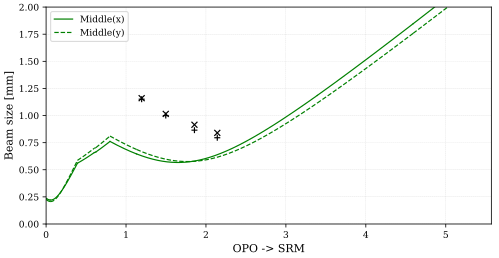

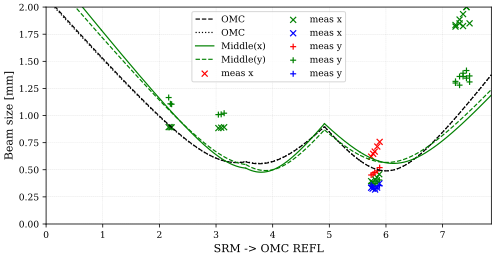

In [49]:
kat = base.deepcopy()

kat.lzm1_zm2.L *= 1
kat.sSRM_FI.L *= 1
kat.sFI_OM1.L *= 1
kat.sOM1_OM2.L *= 1

kat.SRM.Rcx *= 0
kat.SRM.Rcy *= 0

kat.sqz_lens1.f = 250e-3 * 2.23
kat.sqz_lens2.f = 350e-3 * 2.23

run(kat, dz1=dz1-0.03, dz2=dz2+0.1)

This fit looks reasonable considering we still don't have a good explanation for the amount of astigmatism. However the waist position and size of the closest and middle values are looking comparable to https://alog.ligo-wa.caltech.edu/aLOG/index.php?callRep=41504. Furthest is still a bit odd. The astigmatism is large, perhaps the lens2 is not centered or shifted...

Assuming this represents the close and middle results well though we can now shift the lens even closer and check the mismatching to the OMC.

In [170]:
qOMCqx, qOMCqy = cav2node('OMC', 'nSRMs1', kat) # in substrate

qLee      = pykat.BeamParam(w0=608e-6, z=2.7)
qLee.z += 0.88
qMe       = trace_OMCx.q_out
qT1200410 = pykat.BeamParam(q=-3.55 + 1.09j)


print("T1200410, right after SRM:", qT1200410.w, qT1200410.w0, qT1200410.z)
print("Lee, plot                :", qLee.w,      qLee.w0,      qLee.z)
print("Finesse OMC trace        :", qOMCqx.w,     qOMCqx.w0,     qOMCqx.z/1.45)

base.SRM.Rc

OMC -> nSRMs1 (4.93944518678524+1.4714972647978j) (4.92399324456211+1.4824870148395j)
T1200410, right after SRM: 0.00207001841783 0.000607587914298 -3.55
Lee, plot                : 0.00208483650563 0.000608 3.58
Finesse OMC trace        : 0.00205366420906 0.000586336425198 3.406513921920855


<AttrParam (SRM.Rcx=-5.677) at 0x1822535f60>

In [23]:
def run_change_lens2(kat):
    fig2 = plt.figure(figsize=(4*2, 4))
    ax2 = plt.subplot(111)

    OMCqx, OMCqy = cav2node('OMC', 'nSRM2', kat)
    OMCqx.reverse()
    OMCqy.reverse()

    trace_OMCx = kat.beamTrace(OMCqx, 'nSRM2', "nOMC_REFL",'x')
    trace_OMCx.plot_beamsize(ax=ax2, color='k', ls='--', label="OMC")

    trace_OMCy = kat.beamTrace(OMCqy, 'nSRM2', "nOMC_REFL",'y')
    trace_OMCy.plot_beamsize(ax=ax2, color='k', ls=':', label="OMC")

    # Here shift the lens 2 and 4 cm closer compared to the cloest position, and see what happens...
    for dl,c,pos in zip([0e-2, 2e-2, 4e-2], ['r','g','b'], ['0cm', '2cm', '4cm']):
        pos = "%.2f cm" % (dl*100)
        lens2_pos = 0.95 # factor of 0.95 for total 42mm range, is kind of right for the closest measurement we did before
        
        shift_lenses(kat, 0, lens2_pos, dl)
        
        trace_SQZ_SRMx = kat.beamTrace(kat.sqz.nSQZ.qx, 'nSQZ', "nSRMs2",'x')
        
        qx = single_bounce_SQZ(kat, 'x', False, 'nSRM2')

        trace_SRM_OMCx = kat.beamTrace(qx, 'nSRM2', "nOMC_REFL",'x')
        trace_SRM_OMCx.plot_beamsize(ax=ax2, color=c, label=pos + '(x)')

        trace_SQZ_SRMy = kat.beamTrace(kat.sqz.nSQZ.qy, 'nSQZ', "nSRMs2",'y')
        
        qy = single_bounce_SQZ(kat, 'y', False, 'nSRMs2')

        trace_SRM_OMCy = kat.beamTrace(qy, 'nSRMs2', "nOMC_REFL",'y')
        trace_SRM_OMCy.plot_beamsize(ax=ax2, color=c, label=pos + '(y)', ls='--')

        print(pos, "x mismatch", pykat.BeamParam.overlap(trace_SRM_OMCx.q_out, trace_OMCx.q_out))
        print(pos, "y mismatch", pykat.BeamParam.overlap(trace_SRM_OMCy.q_out, trace_OMCy.q_out))

    ax2.set_xlabel("SRM AR -> OMC REFL")
    ax2.legend()
    ax2.set_ylim(0,3)

    ax2.set_xlim(5.3, 6.5)
    ax2.set_ylim(0, 1)

OMC -> nSRM2 (3.35633359166686+1.01508402834356j) (3.34567436712542+1.02266509560728j)
0.00 cm x mismatch 0.8116437399286461
0.00 cm y mismatch 0.8160690919383896
2.00 cm x mismatch 0.7472883795386941
2.00 cm y mismatch 0.751795582013662
4.00 cm x mismatch 0.6464238025944787
4.00 cm y mismatch 0.6500112123839962


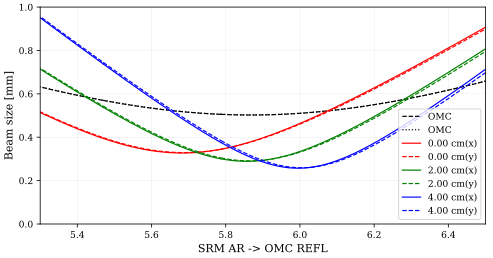

In [24]:
kat = base.deepcopy()
kat.lzm1_zm2.L = 2260e-3
kat.sOM1_OM2.L = 1.39
run_change_lens2(kat)

So we see that the mode matching gets worse as we move lens2 closer...

The waist position gets better but it also gets smaller which hurts us.

In [39]:
def run_change_lens1(kat):
    fig2 = plt.figure(figsize=(4*2, 4))
    ax2 = plt.subplot(111)

    OMCqx, OMCqy = cav2node('OMC', 'nSRM2', kat)
    OMCqx.reverse()
    OMCqy.reverse()

    trace_OMCx = kat.beamTrace(OMCqx, 'nSRM2', "nOMC_REFL",'x')
    trace_OMCx.plot_beamsize(ax=ax2, color='k', ls='--', label="OMC")

    trace_OMCy = kat.beamTrace(OMCqy, 'nSRM2', "nOMC_REFL",'y')
    trace_OMCy.plot_beamsize(ax=ax2, color='k', ls=':', label="OMC")

    # Here shift the lens 2 and 4 cm closer compared to the cloest position, and see what happens...
    for dl,c,pos in zip([2e-2, 4e-2, 10e-2], ['r','g','b'], ['0cm', '2cm', '4cm']):
        pos = "%.2f cm" % (dl*100)
        
        shift_lenses(kat, dl, 0.95, 10e-2)
        
        trace_SQZ_SRMx = kat.beamTrace(kat.sqz.nSQZ.qx, 'nSQZ', "nSRMs2",'x')
        
        qx = single_bounce_SQZ(kat, 'x', False, 'nSRM2')

        trace_SRM_OMCx = kat.beamTrace(qx, 'nSRM2', "nOMC_REFL",'x')
        trace_SRM_OMCx.plot_beamsize(ax=ax2, color=c, label=pos + '(x)')

        trace_SQZ_SRMy = kat.beamTrace(kat.sqz.nSQZ.qy, 'nSQZ', "nSRMs2",'y')
        
        qy = single_bounce_SQZ(kat, 'y', False, 'nSRMs2')

        trace_SRM_OMCy = kat.beamTrace(qy, 'nSRMs2', "nOMC_REFL",'y')
        trace_SRM_OMCy.plot_beamsize(ax=ax2, color=c, label=pos + '(y)', ls='--')

        print(kat.lsqz_lens1.L.value, kat.lsqz_lens1_lens2.L.value, kat.lsqz_lens2_zm1.L.value)
        print(pos, "x mismatch", pykat.BeamParam.overlap(trace_SRM_OMCx.q_out, trace_OMCx.q_out))
        print(pos, "y mismatch", pykat.BeamParam.overlap(trace_SRM_OMCy.q_out, trace_OMCy.q_out))

    ax2.set_xlabel("SRM AR -> OMC REFL")
    ax2.legend()
    ax2.set_ylim(0,3)

    ax2.set_xlim(5.3, 6.5)
    ax2.set_ylim(0, 1)

OMC -> nSRM2 (3.35633359166686+1.01508402834356j) (3.34567436712542+1.02266509560728j)
0.29040369815776446 0.42944540041158175 0.34115090143065374
2.00 cm x mismatch 0.4692826258223514
2.00 cm y mismatch 0.4706146665649061
0.2704036981577645 0.4494454004115817 0.3411509014306538
4.00 cm x mismatch 0.6093191279601461
4.00 cm y mismatch 0.6114574148816694
0.21040369815776447 0.5094454004115817 0.34115090143065374
10.00 cm x mismatch 0.9822958097670965
10.00 cm y mismatch 0.9836766738908271


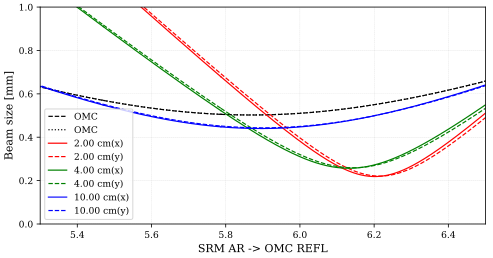

In [40]:
kat = base.deepcopy()
kat.lzm1_zm2.L = 2260e-3
kat.sOM1_OM2.L = 1.39
run_change_lens1(kat)

In [62]:
def run_change_lens1_lens2(kat, dz1, dz2, f1, f2, plot=False, **kwargs):
    if plot:
        fig2 = plt.figure(figsize=(4*2, 4))
        ax2 = plt.subplot(111)

    kat.sqz_lens1.f = f1
    kat.sqz_lens2.f = f2
    
    OMCqx, OMCqy = cav2node('OMC', 'nSRM2', kat)
    OMCqx.reverse()
    OMCqy.reverse()

    trace_OMCx = kat.beamTrace(OMCqx, 'nSRM2', "nOMC_REFL",'x')
    trace_OMCy = kat.beamTrace(OMCqy, 'nSRM2', "nOMC_REFL",'y')

    if plot: trace_OMCy.plot_beamsize(ax=ax2, color='k', ls=':', label="OMC")
    if plot: trace_OMCx.plot_beamsize(ax=ax2, color='k', ls='--', label="OMC")

    kat.data['fn_OPO_shift_lenses'](kat, dz1, 0.5, dz2)
    
    trace_SQZ_SRMx = kat.beamTrace(kat.sqz.nSQZ.qx, 'nSQZ', "nSRMs2",'x')

    qx = single_bounce_SQZ(kat, 'x', False, 'nSRM2')

    trace_SRM_OMCx = kat.beamTrace(qx, 'nSRM2', "nOMC_REFL",'x')
    
    if plot: trace_SRM_OMCx.plot_beamsize(ax=ax2, **kwargs)

    trace_SQZ_SRMy = kat.beamTrace(kat.sqz.nSQZ.qy, 'nSQZ', "nSRMs2",'y')

    qy = single_bounce_SQZ(kat, 'y', False, 'nSRMs2')

    trace_SRM_OMCy = kat.beamTrace(qy, 'nSRMs2', "nOMC_REFL",'y')
    kwargs['ls'] = '--'
    if plot: trace_SRM_OMCy.plot_beamsize(ax=ax2, **kwargs)

    print("x mismatch", pykat.BeamParam.overlap(trace_SRM_OMCx.q_out, trace_OMCx.q_out))
    print("y mismatch", pykat.BeamParam.overlap(trace_SRM_OMCy.q_out, trace_OMCy.q_out))

    if plot:
        ax2.set_xlabel("SRM AR -> OMC REFL")
        ax2.legend()
#         ax2.set_ylim(0,3)

#         ax2.set_xlim(5.3, 6.5)
#         ax2.set_ylim(0, 1)

OMC -> nSRM2 (3.35633359166686+1.01508402834356j) (3.34567436712542+1.02266509560728j)
x mismatch 0.9920914864771931
y mismatch 0.9817419265472233


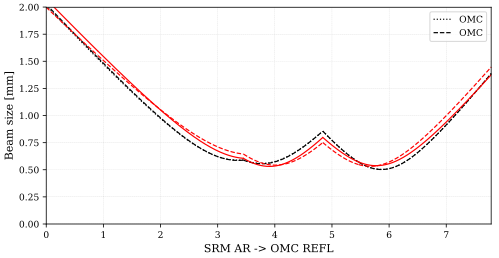

In [208]:
kat = base.deepcopy()
kat.lzm1_zm2.L = 2260e-3
kat.sOM1_OM2.L = 1.39

kat.lzm1_zm2.L *= 1
kat.sSRM_FI.L *= 1
kat.sFI_OM1.L *= 1
kat.sOM1_OM2.L *= 1


run_change_lens1_lens2(kat, dz1, dz2, 250e-3 *2.23, 350e-3*2.23, plot=True, c='r')

OMC -> nSRM2 (3.35633359166686+1.01508402834356j) (3.34567436712542+1.02266509560728j)
x mismatch 0.9878634137789853
y mismatch 0.9756064199993543


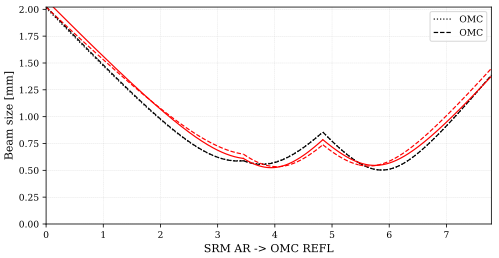

In [435]:
run_change_lens1_lens2(kat, dz1, dz2-2e-2, 0.250 *2.23, 0.350*2.23, plot=True, c='r')

# Test initial design settings

OMC -> nSRM2 (3.35633359166686+1.01508402834356j) (3.34567436712542+1.02266509560728j)
x mismatch 0.8404764912313278
y mismatch 0.842355249784746
Difference to design -0.01091000000000003 -0.021652000000000116


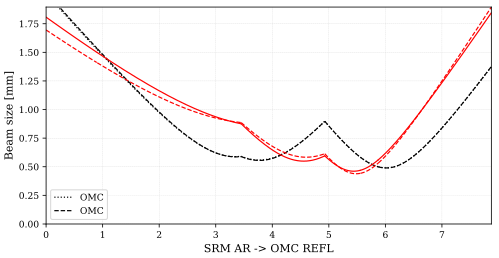

In [140]:
kat = base.deepcopy()
kat.lsqz_faraday.n = 1 # design doesn't consider faraday crystal

# Design distance from OPO M1 to lenses so subtract difference?
dOPO2lens1 = 13.60 * 25.4e-3 - 44e-3 - 6.35e-3 - kat.data['OPO_block_to_lens1']
dOPO2lens2 = 34.87 * 25.4e-3 - 44e-3 - 6.35e-3 - kat.data['OPO_block_to_lens2']

# use difference to shift from our measured model
# Awkward minus sign as function shifts the lenses towards the OPO
kat.data['fn_OPO_shift_lenses'](kat, -dOPO2lens1, 0.5, -dOPO2lens2)

run_change_lens1_lens2(kat, -dOPO2lens1, -dOPO2lens2, 111e-3, 333e-3, plot=True, c='r')

print("Difference to design", dOPO2lens1,dOPO2lens2)

In [86]:
print(kat & "squeezer")

###########################################################################
#sqz sqz 0 0 0 nSQZ
l sqz 0.0 0.0 0.0 nSQZ
bs M1_OPO 0.0 1.0 0.0 6.0 nSQZ dump nM1_OPOc dump
s subM1_OPO 0.006315214035588535 1.44963098985906 nM1_OPOc nM1_OPO_ARa
bs M1_OPO_AR 0.0 1.0 0.0 4.13501223466916 nM1_OPO_ARa dump nM1_OPO_ARc dump
s lM1_OPO_EDGE 0.04375896339620402 nM1_OPO_ARc nOPO_EDGEa
m OPO_EDGE 0.0 1.0 0.0 nOPO_EDGEa nOPO_EDGEb
# edge of OPO block
s lsqz_lens1 0.30271 nOPO_EDGEb nSQZa
lens sqz_lens1 0.111 nSQZa nSQZb
s lsqz_lens1_faraday 0.24929 nSQZb nSQZc
# 20 mm TGG faraday crystal
m msqz_faraday_a 0.0 1.0 0.0 nSQZc nSQZd
s lsqz_faraday 0.02 nSQZd nSQZe
m msqz_faraday_b 0.0 1.0 0.0 nSQZe nSQZf
s lsqz_faraday_lens2 0.27096800000000004 nSQZf nSQZg
lens sqz_lens2 0.333 nSQZg nSQZh
s lsqz_lens2_zm1 0.23903199999999974 nSQZh nZM1a
bs1 ZM1 0.0 0.0 0.0 45.0 nZM1a nZM1b dump dump
s lzm1_zm2 2.26 nZM1b nZM2a
bs1 ZM2 0.0 0.0 0.0 45.0 nZM2a nZM2b dump dump
s lzm2_OFI 1.2 nZM2b nFI2b
#######################

In [139]:
((kat.sqz.nSQZ.qx.w0/1e-6) + (kat.sqz.nSQZ.qy.w0/1e-6))/2

214.05000000000001

In [88]:
15.90 * 25.4e-3 , kat.data['OPO_block_to_lens1']

(0.40386, 0.306)

In [142]:
base.SRM.Rc

<AttrParam (SRM.Rcx=-5.677) at 0x1813aea8d0>

In [248]:
print(base &  "OMC")

###########################################################################
# OMC (as built parameters: D1300507-v1)
# Input Coupler IC (flat mirror)
bs1 OMC_IC 0.0076 1e-05 0.0 2.7609 nOMC_ICa nOMC_ICb nOMC_ICc nOMC_ICd
# Distance from IC to OC
s lIC_OC 0.2815 nOMC_ICc nOMC_OCa
# Output Coupler OC (flat mirror)
bs1 OMC_OC 0.0075 1e-05 0.0 4.004 nOMC_OCa nOMC_OCb nAS nOMC_OCd
# Distance from OC to CM1
s lOC_CM1 0.2842 nOMC_OCb nOMC_CM1a
# Curved Mirror CM1
bs1 OMC_CM1 3.6e-05 1e-05 0.0 4.004 nOMC_CM1a nOMC_CM1b nOMC_CM1c nOMC_CM1d
attr OMC_CM1 Rcx 2.57321
attr OMC_CM1 Rcy 2.57321
# Distance from CM1 to CM2
s lCM1_CM2 0.2815 nOMC_CM1b nOMC_CM2a
# Curved Mirror CM2
bs1 OMC_CM2 3.59e-05 1e-05 0.0 4.004 nOMC_CM2a nOMC_CM2b nOMC_CM2c nOMC_CM2d
attr OMC_CM2 Rcx 2.57369
attr OMC_CM2 Rcy 2.57369
# Distance from CM2 to IC
s lCM2_IC 0.2842 nOMC_CM2b nOMC_ICd
###########################################################################
